# synloc: A Local Resampler Algorithm to Create Synthetic Data

<p align="center">
  <img src="logo_white_bc.png" />
</p>

`synloc` is an algorithm to sequentially and locally estimate distributions to create synthetic values from a sample. The proposed methodology can be combined with parametric and nonparametric distributions. 

# Installation

`synloc` can be installed through [PyPI](https://pypi.org/):

```
pip install synloc
```
(not done yet)
# Examples

Assume that we have a sample with three variables with the following distributions:

$$
\begin{aligned}
x &\sim Beta(0.1,\,0.1)\\
y &\sim Beta(0.1,\, 0.5)\\
z &\sim 10 * y + Normal(0,\,1)
\end{aligned}
$$

The distribution can be generated by `tools` module in `synloc`:

In [1]:
from synloc.tools import sample_trivariate_xyz
data = sample_trivariate_xyz() # Generates a sample with size 1000 by default. 

## Creating synthetic values with Multivariate Normal Distribution

Initializing the resampler:

In [2]:
from synloc import LocalCov
resampler = LocalCov(data = data, K = 30)

**Subsample** size is defined as `K=30`. Now, we locally estimate the multivariate normal distribution and from each estimated distributions we draw "synthetic values."

In [3]:
syn_data = resampler.fit() 

100%|██████████| 1000/1000 [00:01<00:00, 687.53it/s]


The default sample size is the size of the original sample (i.e., 1000). It can be changed while fitting the distributions:

```python
syn_data = resampler.fit(100) # a sample with size 100 created.
```


`syn_data` is a [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) where all variables are synthesized. 

Comparing the original sample using a 3-D Scatter:

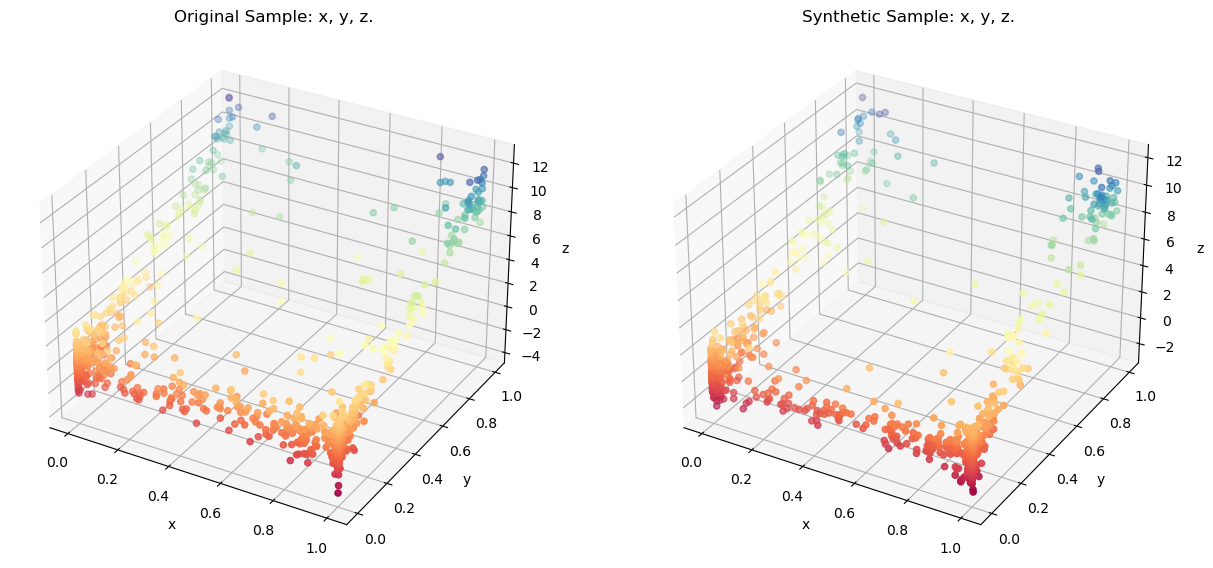

In [4]:
resampler.comparePlots(['x','y','z'])

## Creating synthetic values with Gaussian Copula

Initializing the resampler:

In [5]:
from synloc import LocalGaussianCopula
resampler = LocalGaussianCopula(data = data, K = 30)

We locally estimate the `Gaussian Copula` and from each estimated distributions we draw "synthetic values."

In [6]:
syn_data_copula = resampler.fit() 

100%|██████████| 1000/1000 [00:03<00:00, 272.71it/s]


Comparing the original sample using a 3-D Scatter:

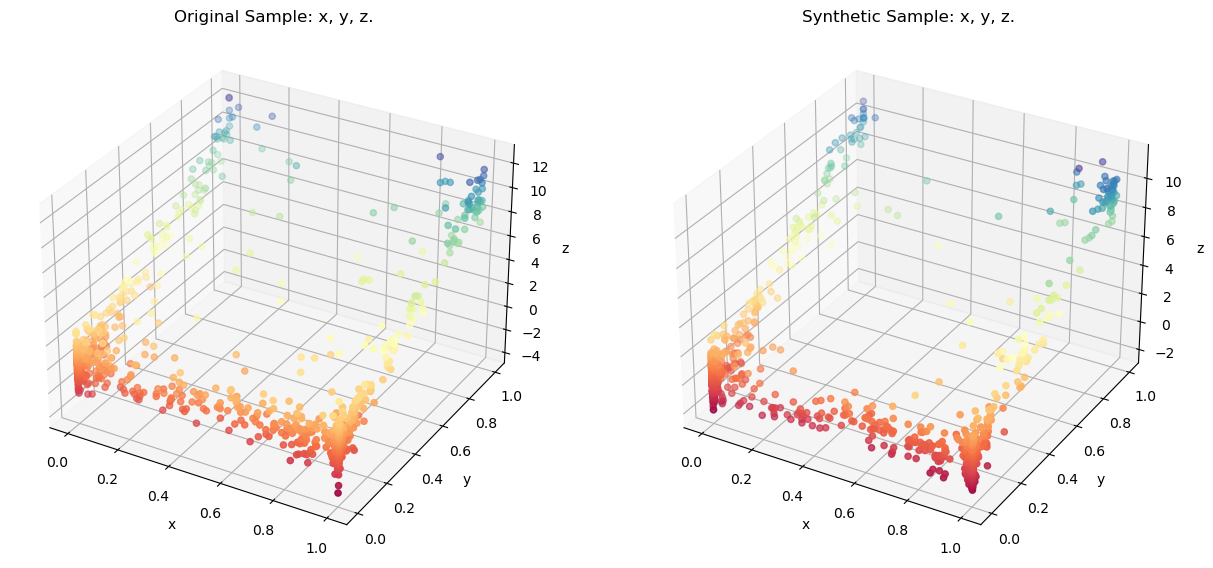

In [7]:
resampler.comparePlots(['x','y','z'])

Even though the distribution of the original sample substantially differs from multivariate normal, locally estimated distributions can replicate the original distribution quite accurately. 

# Customized Models

`kNNResampler` class can be used to utilize estimate and resample from any distributions. 

## functional Principal Component Analysis (fPCA)

For example, if the original sample is high-dimensional data, the user can reduce the dimension with **fPCA**. It is possible to implement it with [FPCADataGenerator](https://dmey.github.io/synthia/fpca.html) function in [Synthia](https://github.com/dmey/synthia) package:

In [8]:
from synloc import kNNResampler
from synloc.tools import stochastic_rounder
from synthia import FPCADataGenerator

class LocalFPCA(kNNResampler):
    def __init__(self, data, K = 30, normalize = True, clipping = True, Args_NearestNeighbors = {}):
        super().__init__(data, K, normalize, clipping, Args_NearestNeighbors, method = self.method)
    def method(self, data):
        generator = FPCADataGenerator()
        generator.fit(data, n_fpca_components=2)
        return generator.generate(1)[0]

Using `kNNResampler` as a parent class, we created `LocalFPCA`. The key component is defining the method for `kNNSampler`. 

```python
super().__init__(data, K, normalize, clipping, Args_NearestNeighbors, method = self.method)
```

In the `LocalFPCA` class we define the `self.method`:

```python
def method(self, data):
    generator = FPCADataGenerator()
    generator.fit(data, n_fpca_components=2) # reducing dimension to 2
    return generator.generate(1)[0]
```


### Example

100%|██████████| 1000/1000 [00:02<00:00, 346.47it/s]


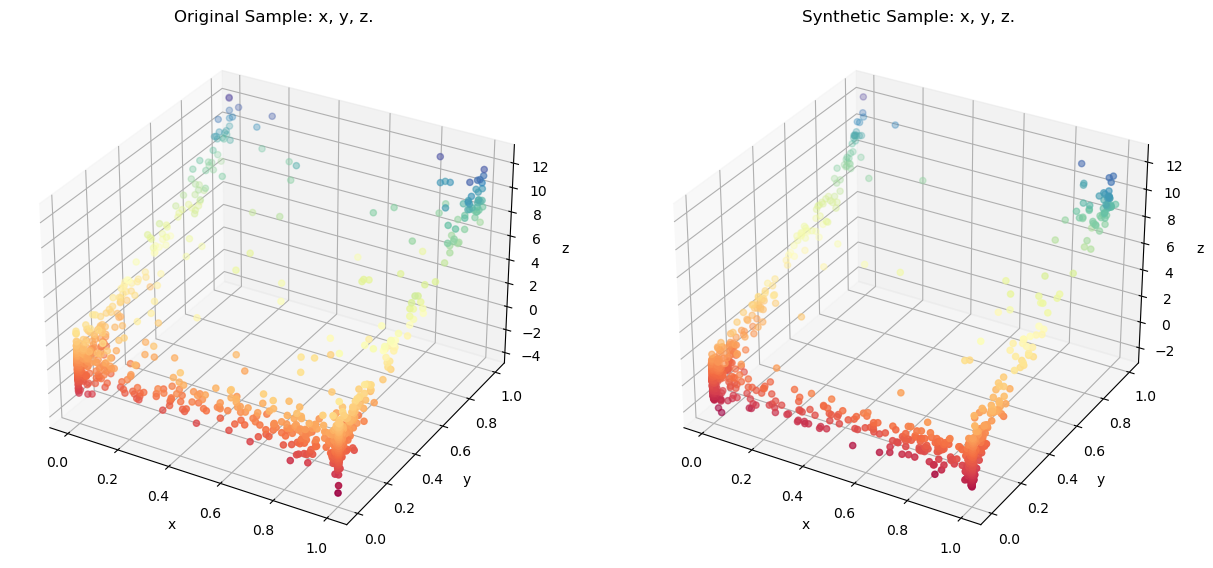

In [9]:
resampler = LocalFPCA(data = data)
resampler.fit()
resampler.comparePlots(['x','y','z'])

## Problem with Discrete Variables

So far, we assumed that original data set contains only continuous variables. It is possible to address this problem by rounding these variables (stochastically or deterministically), or we can use some multivariate distributions that can handle the mixed type variables. Then, we need to define a new a subclass of `kNNSampler`. 

One solution is it use [mixedvines](https://github.com/asnelt/mixedvines) package. It allows to specify the discrete type variables. 

In [10]:
from synloc import kNNResampler
from mixedvines.mixedvine import MixedVine # pip install mixedvines


class LocalMixedVine(kNNResampler):
    def __init__(self, data, cont_cols, K = 30, normalize = True, clipping = True, Args_NearestNeighbors = {}):
        super().__init__(data, K, normalize, clipping, Args_NearestNeighbors, method = self.method)
        self.cont_cols = cont_cols
    
    def method(self, data):
        generator = MixedVine.fit(data.values, self.cont_cols)
        return generator.rvs(1)[0]

`LocalMixedVine` takes the argument `cont_cols` which is a boolean list. `True` if it is a continuous variable, `False` if it is discrete. Further, specification can be done following the [documentation](https://mixedvines.readthedocs.io/en/latest/). 

### Example

100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


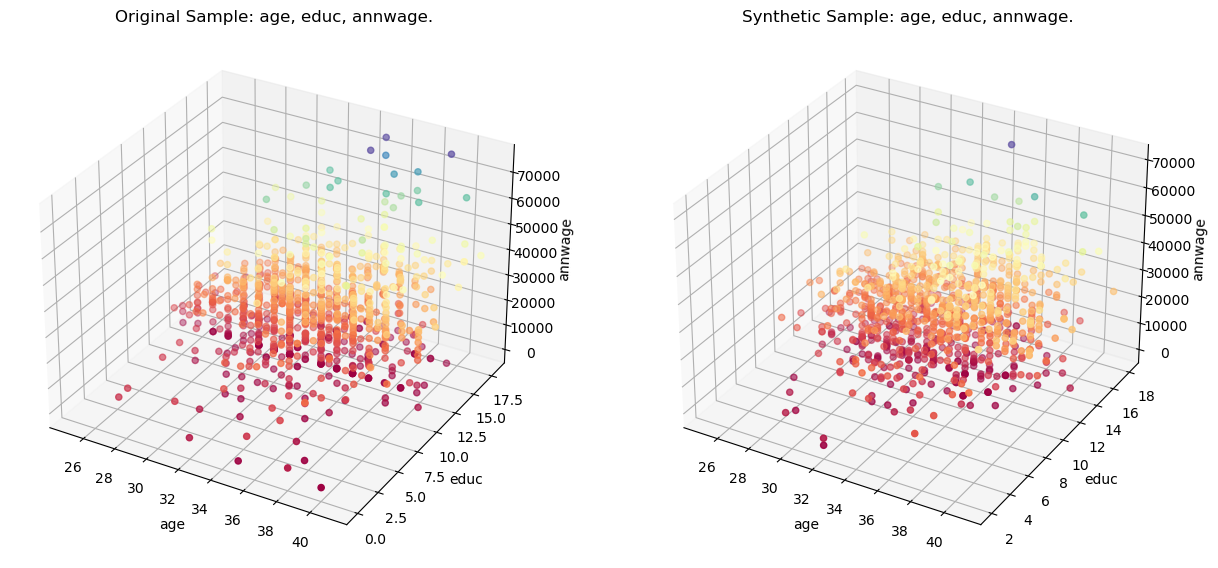

In [29]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=RuntimeWarning) 

data2 = pd.read_stata('../extract.dta')
data2 = data2[['age','educ', 'annwage']]
data2 = data2[~data2.isna().any(1)]
data2.age = data2.age.astype('int')
data2.educ = data2.educ.astype('int')
data2 = data2.sample(1000)

resampler = LocalMixedVine(data = data2, K = 50, cont_cols = [False, False, True])
resampler.fit()
resampler.comparePlots(['age','educ', 'annwage'])

In [33]:
# Original sample looks like
print(data2.head())

       age  educ  annwage
10538   28    12  22801.0
11715   34    16  16000.0
3544    31    11  12500.0
10149   36    13  19000.0
3918    28    16  16993.0


In [32]:
#synthetic sample looks like
print(resampler.synthetic.head())

   age  educ       annwage
0   29    12  16236.643091
1   33    16  18432.093681
2   30    11  12190.666403
3   36    13  20126.695065
4   27    15  23331.840903


In [1]:
!jupyter nbconvert --output-dir='..' --to markdown README.ipynb

C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2202: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '..' instead of "'..'" if you require traitlets >=5.
  warn(
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files\
[NbConvertApp] Making directory ..\README_files
[NbConvertApp] Making directory ..\README_files
[NbConvertApp] Making directory ..\README_files
[NbConvertApp] Making directory ..\README_files
[NbConvertApp] Writing 9328 bytes to ..\README.md
